# 3章 組み合わせのあるテスト：　要素に分解して考える

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

## 3.1 チャーリーのレポート
ヒーロー画像とボタンの表示を変えた、4つの組み合わせのクリック率をMCMCで推論する。


|ヒーロー画像|ボタン|表示回数|クリック回数|クリック率|
|:-:|:-:|:-:|:-:|:-:|
|A|商品イメージ|434|8|1.84%|
|B|商品イメージ|382|17|4.45%|
|C|サンプル写真|394|10|2.54%|
|D|サンプル写真|88|4|4.55%|


事前分布には一様分布を仮定し、尤度関数が二項分布のモデル

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 8 seconds.


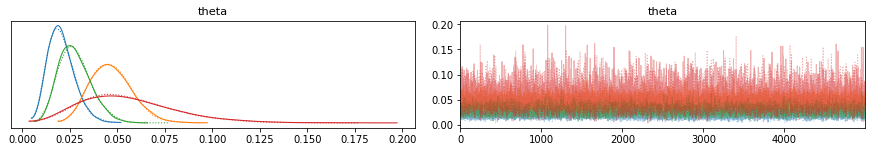

In [ ]:
# A,B,C,Dの表示回数
n = [434, 382, 394, 88]
# クリック数
clicks = [8,17,10, 4]

with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=len(n))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace = pm.sample(5000, chains=2)
  pm.traceplot(trace, compact=True)

↑青がA、オレンジがB、,緑がC、赤がD

In [ ]:
with model:
  display(pm.summary(trace, hdi_prob=0.95))

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],0.021,0.007,0.008,0.034,0.0,0.0,12538.0,11394.0,12254.0,6960.0,1.0
theta[1],0.047,0.011,0.027,0.068,0.0,0.0,15895.0,14186.0,16166.0,7969.0,1.0
theta[2],0.028,0.008,0.013,0.045,0.0,0.0,12986.0,11394.0,13270.0,7758.0,1.0
theta[3],0.056,0.024,0.015,0.105,0.0,0.0,12056.0,10331.0,11944.0,6995.0,1.0


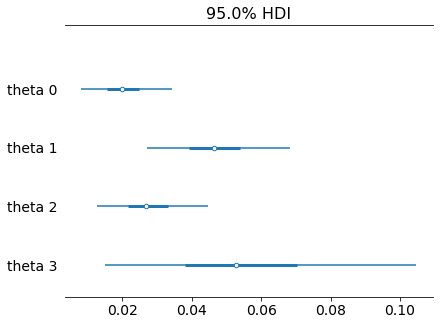

In [ ]:
with model:
  pm.forestplot(trace, combined=True, hdi_prob=0.95)

In [ ]:
#AとBのデザインを比較
print((trace['theta'][:, 1] - trace['theta'][:, 0] > 0).mean())

0.9828


In [ ]:
# AとDを比較
print((trace['theta'][:, 3] - trace['theta'][:, 0] > 0).mean())

0.9455


Bのクリック率は、Aよりも高いと結論づけることができる。
AとDを比較すると、判断基準の95%を下回っているので、DはAよりクリック率が高いと言うことはできない

## 3.2　効果に着目したモデリング

4つのデザインのうち、どれが優れているかよりもヒーロー画像、ボタンの各要素がクリック率に与える効果を知りたい。今後ほかのWebページを作成するときにも活かせる

### ロジスティック関数

ダミー変数(0,1)を導入し、ヒーロー画像の変数をを$x_1$、ボタンの変数$x_2$とする。<br>
ベースラインとなる切片を$\alpha$とし、ヒーロー画像の変数($x_1$)にかかる係数(クリック率への貢献分)を$\beta_1$、ボタン

$$
 logistic(x) = \frac{1}{1+ e^{-x}}
$$

$$
\theta = logistic(\alpha + \beta_1x_1 + \beta_2x_2)
$$

